In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle

Expectation of OU Process: 0.37531109885139957
Variance of OU Process: 0.053933687300356026


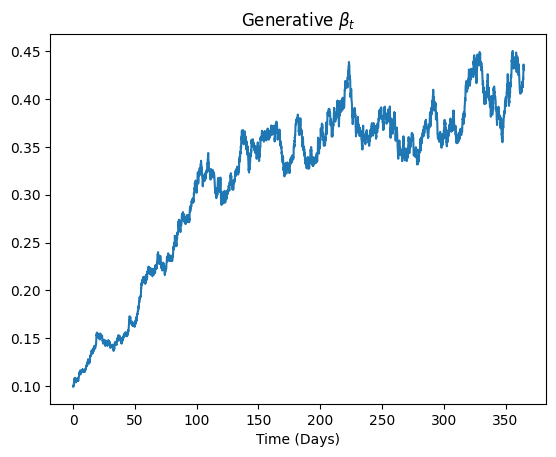

In [2]:
'''Simulated Data, setting up the SIR model'''

rng = np.random.default_rng(100)
model_params = {'gamma':1/10,'xi':1/120,'R':10,'rho':0.7}

T = 365
dt = 0.1

SIRS_OU_model_params = jsonpickle.encode(model_params)

with open("../param_sets/SIRS_OU_rho_model_params.json", "w+") as f:
    f.write(SIRS_OU_model_params)

t_vec = np.arange(0,T,dt)

'''IC'''
N = 500
I = 5

'''OU params'''
OU_params = {'lambda':1/100,'mean_ou':-1.0,'sig':0.2}

SIRS_OU_process_params = jsonpickle.encode(OU_params)
with open("../param_sets/SIRS_OU_rho_process_params.json", "w+") as f:
    f.write(SIRS_OU_process_params)

gamma,xi,R,rho = model_params.values()
lam,mean_ou,sig = OU_params.values()

print(f"Expectation of OU Process: {np.exp(mean_ou + (sig**2)/2)}")
print(f"Variance of OU Process: {np.exp(sig**2 - 1) * np.exp(2 * mean_ou + sig**2)}")


A = np.exp(-lam * dt)
M = mean_ou * (np.exp(-lam * dt) - 1)
C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

betas = np.zeros_like(t_vec)
betas[0] = 0.1
for time_index in range(1,len(t_vec)):
    betas[time_index] = np.exp(A * np.log(betas[time_index - 1]) - M + C * rng.normal(0,1))

state = np.zeros((3,len(t_vec)))
state[:,0] = np.array([N - I,I,0])

plt.title('Generative $\\beta_t$')
plt.xlabel('Time (Days)')
plt.plot(t_vec,betas)

for time_index in range(1,len(t_vec)):
   new_S = rng.poisson((xi * state[2,time_index-1]) * dt)
   new_I = rng.poisson((betas[time_index - 1] * (state[0,time_index-1] * state[1,time_index-1])/np.sum(state[:,time_index-1])) * dt)
   new_R = rng.poisson((gamma * state[1,time_index-1]) * dt)

   state[0,time_index] = np.maximum(0.,state[0,time_index-1] + new_S - new_I)
   state[1,time_index] = np.maximum(0.,state[1,time_index-1] + new_I - new_R)
   state[2,time_index] = np.maximum(0.,state[2,time_index-1] + new_R - new_S)


In [3]:
pd.DataFrame(state).to_csv('../data_sets/ou_SIRS_state_reporting_rate.csv',index = False)
pd.DataFrame(betas).to_csv('../data_sets/ou_SIRS_betas_reporting_rate.csv',index = False)

[[495. 495. 495. ... 103. 102. 102.]
 [  5.   5.   5. ...  36.  36.  36.]
 [  0.   0.   0. ... 361. 362. 362.]]


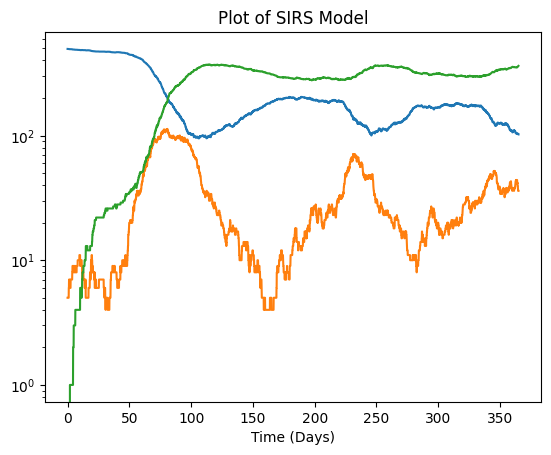

In [4]:
print(state)
plt.yscale('log')
plt.title('Plot of SIRS Model')
plt.xlabel('Time (Days)')
plt.plot(t_vec,state.T)

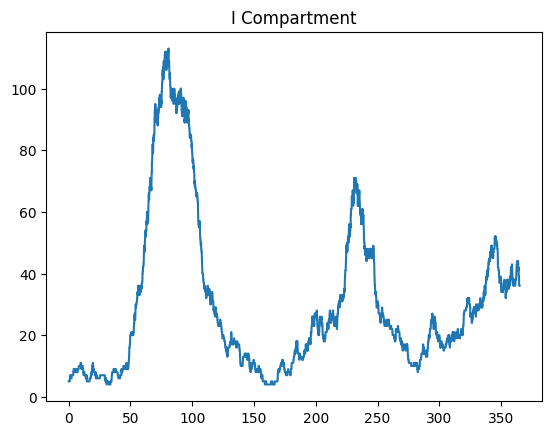

In [5]:
plt.title('I Compartment')
plt.plot(t_vec,state[1,:].T)

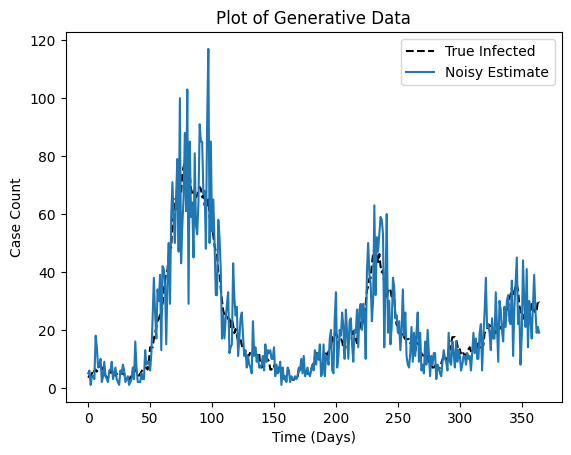

In [6]:

data = np.expand_dims(rng.negative_binomial(n = R,p = R/(R + rho * (state[1,::int(1/dt)] + 0.005))),0)

plt.title('Plot of Generative Data')
plt.xlabel('Time (Days)')
plt.ylabel('Case Count')
plt.plot(t_vec[::int(1/dt)],rho * state[1,::int(1/dt)],'--',color = 'black',label = 'True Infected')
plt.plot(t_vec[::int(1/dt)],data.T,label = 'Noisy Estimate')
plt.legend()

In [7]:
pd.DataFrame(data).to_csv('../data_sets/ou_SIRS_data_reporting_rate.csv',index = False)